## Install:

```bash
pip install jax jaxlib
# pip install autograd
pip install scikit_learn
```

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np
# import autograd.numpy as np
from jax import vmap, grad
# from autograd import elementwise_grad, grad

# Some exercises in automatic differentiation using `autograd` and `jax`

This is a short note on how to use an automatic differentiation library, starting from exercises that feel like calculus, and ending with an application to linear regression using very basic gradient descent.

I am using [autograd](https://github.com/HIPS/autograd) here, though these experiments were originally done using [jax](https://github.com/google/jax), which adds [XLA](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/g3doc/overview.md) support, so everything can run on the GPU. It is strikingly easy to move from `autograd` to `jax`, but the random number generation is _just_ weird enough that the following is run with autograd. I have included the equivalent `jax` code for everyting, though

Automatic differentiation has found intense application in deep learning, but my interest is in probabilistic programming, and gradient-based Markov chain Monte Carlo in particular. There are a number of probabilistic programming libraries built on top of popular deep learning libraries, reaping the benefits of efficient gradients and computation: 
- [PyMC3](https://pymc.io/) uses [Theano](https://github.com/theano/theano), 
- [Pyro](http://pyro.ai/) uses [PyTorch](https://pytorch.org/), and 
- [Edward2](https://www.tensorflow.org/probability/api_docs/python/tfp/edward2) uses [Tensorflow](https://www.tensorflow.org/probability/). 

The [Stan](https://mc-stan.org/) library implements [their own automatic differentiation](https://arxiv.org/abs/1509.07164).

At their simplest, these libraries both work by taking a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ and return the gradient, $\nabla f: \mathbb{R}^n \rightarrow \mathbb{R}^n$. This can be chained to get second or third derivatives.

## Example 1: Derivatives of a function

Here are the first 4 derivatives of the hyperbolic tangent:

In [2]:
f = lambda x: x * x

In [3]:
grad(f)(2.)

/home/colin/miniconda3/envs/bayes_course/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(4., dtype=float32)

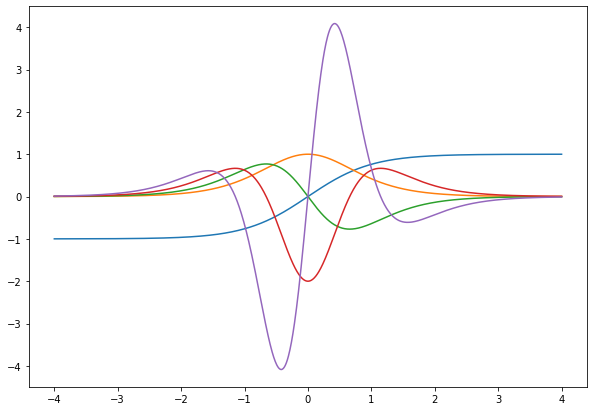

In [4]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.linspace(-4, 4, 1000)

my_func = np.tanh
ax.plot(x, my_func(x))
for _ in range(4):
    my_func = grad(my_func)
    ax.plot(x, vmap(my_func)(x))
    
#     my_func = elementwise_grad(my_func)
#     ax.plot(x, my_func(x))

### Example 2: Trig functions

My _favorite_ way of defining trigonometric functions like sine and cosine are as solutions to the differential equation 
$$
y'' = -y
$$ 

We can use `autograd` to confirm that sine and cosine both satisfy this equality.

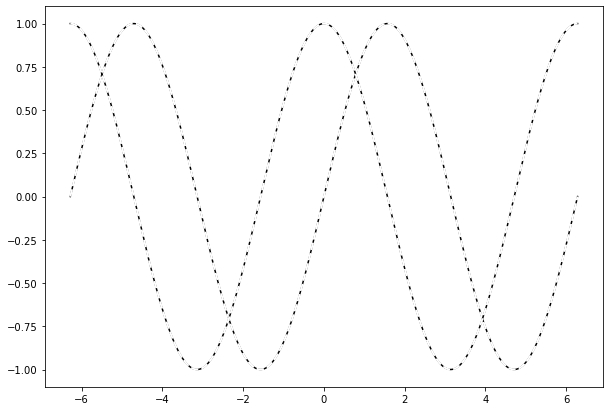

In [5]:
fig, ax = plt.subplots(figsize=(10, 7))

x = np.linspace(-2 * np.pi, 2 * np.pi, 1000)

for func in (np.sin, np.cos):
    second_derivative = grad(grad(func))
    ax.plot(x, func(x), 'k-')
    ax.plot(x, -vmap(second_derivative)(x), 'w--', lw=2)

### Example 3: Linear regression 4 ways

We can also do linear regression quite cleanly with `autograd`. Recall that a common loss function for linear regression is squared error: given data $X$ and targets $\mathbf{y}$, we seek to find a $\mathbf{w}$ that minimizes 
$$
\text{Loss}(\mathbf{w}) = \|X\mathbf{w} - \mathbf{y}\|^2 = \sum_{j=1}^N (\mathbf{x}_j \cdot \mathbf{w} - y_j)^2
$$

One way of doing this is to use gradient descent: initialize a $\mathbf{w}_0$, and then update 
$$
\mathbf{w}_j = \mathbf{w}_{j - 1} + \epsilon \nabla \text{Loss}(\mathbf{w}_{j - 1})
$$

after enough iterations, $\mathbf{w}_j$ will be close to the optimal set of weights.

Another way is to [just use some linear algebra](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse):

$$
\hat{\mathbf{w}} = (X^TX)^{-1}X^T\mathbf{y}
$$

As an exercise, you can check that if $X$ is square and invertible, $(X^TX)^{-1}X^T = X^{-1}$. 

Let's convince ourselves that these two approaches are the same. Keep in mind here our goal is to find a $\hat{\mathbf{w}}$ that minimizes the loss function.

In [6]:
import numpy as onp
onp.random.seed(1)
data_points, data_dimension = 100, 10

# Generate X and w, then set y = Xw + ϵ
X = onp.random.randn(data_points, data_dimension)
true_w = onp.random.randn(data_dimension)
y = X.dot(true_w) + 0.1 * onp.random.randn(data_points)


In [7]:
w_linalg = onp.linalg.pinv(X).dot(y)
w_linalg

array([-0.15786494, -2.44268406,  0.5084408 , -0.32879979, -1.51216469,
       -0.85693355, -0.87325358,  0.62495466,  0.55077236,  1.48814586])

In [8]:

def make_squared_error(X, y):
    def squared_error(w):
        return np.sum(np.power(np.dot(X, w) - y, 2)) / X.shape[0]
    return squared_error

# Now use autograd!
grad_loss = grad(make_squared_error(X, y))

# V rough gradient descent routine. don't use this for a real problem.
w_grad = np.zeros(data_dimension)
epsilon = 0.1
iterations = 100
for _ in range(iterations):
    w_grad = w_grad - epsilon * grad_loss(w_grad)

onp.asarray(w_grad)

array([-0.15786535, -2.4426785 ,  0.5084391 , -0.32879645, -1.5121603 ,
       -0.85692984, -0.8732521 ,  0.6249562 ,  0.55077225,  1.488145  ],
      dtype=float32)

Both our answers agree to within one tenth of one percent, which is exciting, but should not be, because we already did some math.

In [9]:
import pymc3 as pm

In [10]:
with pm.Model() as linalg:
    w_pm = pm.Flat('w', shape=true_w.shape)
    pm.Normal('y', X @ w_pm, 1, observed=y)
    trace = pm.sample()

Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3821.54draws/s]


In [11]:
trace['w'].mean(axis=0)

array([-0.15261329, -2.44036155,  0.50921137, -0.32938842, -1.50854054,
       -0.85795474, -0.87550853,  0.62495576,  0.55073678,  1.49044771])

In [12]:
from sklearn.linear_model import LinearRegression

LinearRegression().fit(X, y).coef_

array([-0.15846063, -2.44278656,  0.50802339, -0.33024641, -1.51235658,
       -0.85668693, -0.87326236,  0.62468093,  0.55061945,  1.48846345])

## Exercise: Ridge regression four ways

Perform all the above analysis for *Ridge regression.*

1. To optimize this with `jax`, recall that the loss function becomes

$$
\text{Loss}_{\alpha}(\mathbf{w}) = \|X\mathbf{w} - \mathbf{y}\|^2 + \alpha \|w\|^2 = \sum_{j=1}^N (\mathbf{x}_j \cdot \mathbf{w} - y_j)^2 + \alpha \| \mathbf{w}\|^2
$$

where $\alpha$ is the regularization strength.

2. To optimize with numpy, it turns out that the closed-form solution is now 
$$
\hat{\mathbf{w}} = (X^TX + \alpha I)^{-1}X^T\mathbf{y}
$$

3. To optimize with `pymc3`, recall that ridge regression is equivalent to a normal prior on the weights with standard deviation $\tau$, observation standard deviation $\sigma$, and with $\alpha = \sigma^2 / \tau^2$, 

4. You can use `from sklearn.linear_model import Ridge` in scikit-learn.

# Hamiltonian Monte Carlo



In [13]:
import scipy.stats as st

def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=1, step_size=0.5):
    # jax magic
    dVdq = vmap(grad(negative_log_prob))

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want 100 x 10 momentum draws
    # we can do this in one call to np.random.normal, and iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(onp.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(samples[-1])

    return np.array(samples[1:])


def leapfrog(q, p, dVdq, path_len, step_size):
    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p

In [14]:
from jax.scipy.stats import norm

In [15]:
def neg_log_p(x):
    return -norm.logpdf(2 * (x - 10))

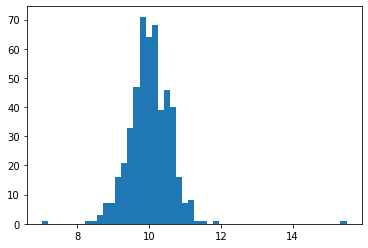

In [16]:
plt.hist(hamiltonian_monte_carlo(500, neg_log_p, np.array([0.])).T, bins='auto');